In [24]:
# Applied CIO Mini-Project
# Author: Robert Barbulescu

# Import matplotlib library
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from time import time
import logging
import seaborn as sns

# Import scikit-learn library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from statistics import mean
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB

In [2]:
#  Data Preprocessing, this is mainly for comparison purposes, we have also declared similar values below for the actual classification
def processing( min_faces, fraction = 1, verbose = True, test_split = True, special_params = False):
  if special_params:
      dataset = fetch_lfw_people(min_faces_per_person = min_faces,  slice_=None,  resize=1.)
  else:
      dataset = fetch_lfw_people(min_faces_per_person = min_faces)
  X = dataset.data
  n_features = X.shape[1]

  if verbose: 
    targets = dataset.target_names
    n_classes = targets.shape[0]

  y = dataset.target
  # select fraction from dataset
  if fraction != 1:
    X, n, y, n = train_test_split(X, y, train_size = fraction, random_state = 42)

  X_scaled = MinMaxScaler().fit_transform(X)
  
  if test_split:
    train_data, test_data, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42) 
    return train_data, y_train, test_data, y_test
  return X_scaled, y

In [3]:
# used for better plots
plt.style.use('ggplot')

In [4]:
# download the LFW_people's dataset
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)
  
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
  
# Instead of providing 2D data, X has data already in the form  of a vector that
# is required in this approach.
X = lfw_people.data
n_features = X.shape[1]
  
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
  
# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  1288
Size of a data sample:  1850
Number of Class Labels:  7


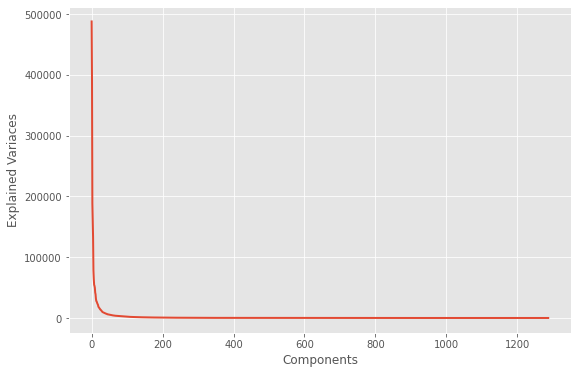

In [43]:
# Finding Optimum Number of Principle Component, this is helpful to set the right parameters 
pca = PCA()
pca.fit(X)
plt.figure(1, figsize=(9,6))
plt.plot(pca.explained_variance_, linewidth=2)
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

In [6]:
# Naive Bayes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
g_precision, g_recall, g_f_score, _ = [mean(x) for x in precision_recall_fscore_support(y_test, y_pred)]
print("Precision : %s, Recall : %s, F-score : %s" %( g_precision, g_recall, g_f_score))

Precision : 0.36126719701220716, Recall : 0.41479791384747766, F-score : 0.36733544690549136


In [7]:
# Comparison between SVM methods to determine best for usage in classification
min_faces = 70

X_scaled, y = processing(min_faces, verbose = False, test_split=False)

pca = PCA(n_components = 150)
X_reduced = pca.fit_transform(X_scaled)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.2, random_state = 42)

#  parameters for comparisson 
p_grid = {"C": [1, 10, 100, 1000],
          "gamma": [0.0001, 0.001, .01, .1]}

polynomial_svm = SVC(kernel = 'poly')
rbf_svm = SVC(kernel = 'rbf')

N_TRIALS = 3

polynomial_scores = np.zeros(N_TRIALS)
rbf_scores = np.zeros(N_TRIALS)

polynomial_clf = GridSearchCV(estimator = polynomial_svm, param_grid=p_grid)
rbf_clf = GridSearchCV(estimator = rbf_svm, param_grid=p_grid)
polynomial_clf.fit(X_train_pca, y_train)
rbf_clf.fit(X_train_pca, y_train)
print("Best parameters for polynomial kernel : ", polynomial_clf.best_estimator_)
print("Best parameters for rbf kernel : ", rbf_clf.best_estimator_)

Best parameters for polynomial kernel :  SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best parameters for rbf kernel :  SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [8]:
# Performing training
polynomial_svm = SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly')
rbf_svm = SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf')
    
polynomial_y_pred = polynomial_svm.fit(X_train_pca, y_train).predict(X_test_pca)
rbf_y_pred = rbf_svm.fit(X_train_pca, y_train).predict(X_test_pca)

polynomial_precision, polynomial_recall, polynomial_f_score, _ = [mean(x) for x in precision_recall_fscore_support(y_test, polynomial_y_pred)]
rbf_precision, rbf_recall, rbf_f_score, _ =  [mean(x) for x in precision_recall_fscore_support(y_test, rbf_y_pred)]

polynomial_svm = SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly')

rbf_svm = SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf')

polynomial_y_pred = polynomial_svm.fit(X_train_pca, y_train).predict(X_test_pca)
rbf_y_pred = rbf_svm.fit(X_train_pca, y_train).predict(X_test_pca)

polynomial_precision, polynomial_recall, polynomial_f_score, _ = [mean(x) for x in precision_recall_fscore_support(y_test, polynomial_y_pred)]
rbf_precision, rbf_recall, rbf_f_score, _ =  [mean(x) for x in precision_recall_fscore_support(y_test, rbf_y_pred)]

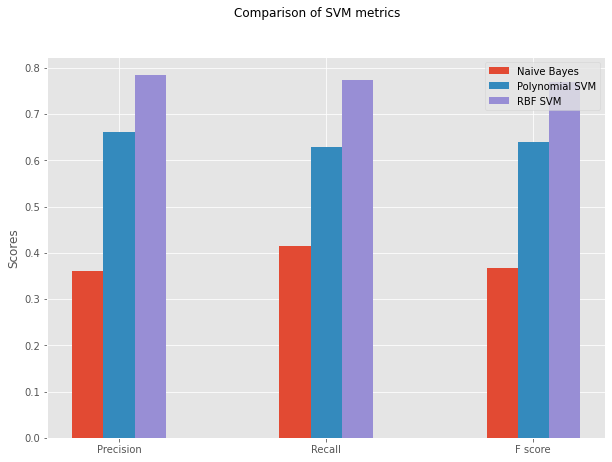

In [9]:
fig, axs = plt.subplots( figsize=(10, 7))
fig.suptitle('Comparison of SVM metrics')

x = [0, 1, 2]
width = 0.15

# Precision
gaussian = axs.bar([a - width for a in x], [g_precision, g_recall, g_f_score], width, label='Naive Bayes')
polynomial = axs.bar([a for a in x], [polynomial_precision, polynomial_recall, polynomial_f_score], width, label='Polynomial SVM')
rbf= axs.bar([a + width for a in x], [rbf_precision, rbf_recall, rbf_f_score], width, label='RBF SVM')

axs.set_ylabel('Scores')
axs.set_xticks(x)
axs.set_xticklabels(["Precision", "Recall", "F score"])
axs.legend()

plt.show()

In [10]:
# Visualization
def plot_gallery(images, titles, h, w, rows=3, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

def titles(y_pred, y_test, target_names):
    for i in range(y_pred.shape[0]):
        pred_name = target_names[y_pred[i]].split(' ')[-1]
        true_name = target_names[y_test[i]].split(' ')[-1]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)

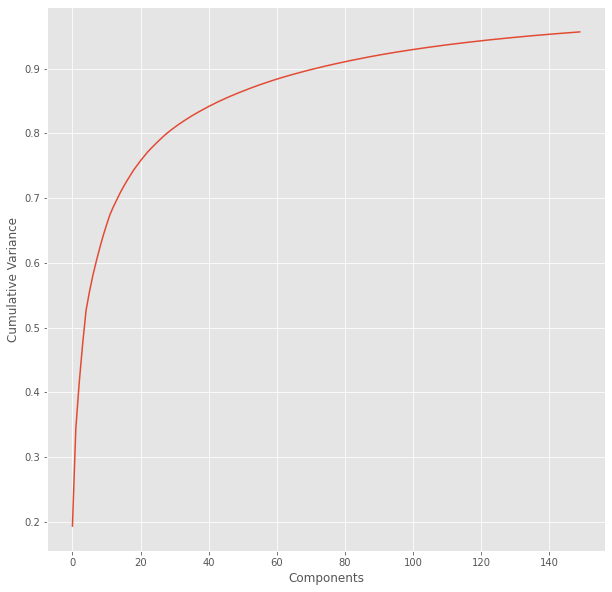

In [13]:
# Ploting the variance will show that is not necessary to consider a large number of dimensions in order to build a face recognition model
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Cumulative Variance');

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42)
print("Size of training Data is % d and Testing Data is % d" %(
        y_train.shape[0], y_test.shape[0]))

n_components = 150
  
pca = PCA(n_components = n_components, svd_solver ='randomized',
          whiten = True).fit(X_train)

t0 = time()
eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Sample Data point after applying PCA\n", X_train_pca[0])
print("-----------------------------------------------------")
print("Dimesnsions of training set = % s and Test Set = % s"%(
        X_train.shape, X_test.shape))
        
print("Fitting the classifier to the training set")

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel ='rbf', class_weight ='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))

print("Best estimator found by grid search:")
print(clf.best_estimator_)
  
print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)
print("Accuracy score:{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))

# print classifiction results
print(classification_report(y_test, y_pred, target_names = target_names))
# print confusion matrix
print("Confusion Matrix is:")
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Size of training Data is  966 and Testing Data is  322
Projecting the input data on the eigenfaces orthonormal basis
Sample Data point after applying PCA
 [-2.0756028  -1.045793    2.1269357   0.03682365 -0.7575711  -0.5173715
  0.85550207  1.051939    0.45773703  0.01347819 -0.03962816  0.63872916
  0.48167613  2.3378136   1.7785014   0.13309602 -2.2713542  -4.4569035
  2.0977387  -1.1379303   0.18843555 -0.33501992  1.1254503  -0.32402474
  0.14095168  1.0769691   0.7588102  -0.09976135  3.1199448   0.88380575
 -0.89336574  1.1596013   1.4307021   1.6855791   1.3435056  -1.2591196
 -0.63912797 -2.336324   -0.01368536 -1.4638544  -0.46888125 -1.0547376
 -1.3327434   1.1364875   2.2223558  -1.8014791  -0.306428   -1.028253
  4.773374    3.460265    1.9260808  -1.3516129  -0.25883847  2.0104134
 -1.0562344   0.36126462  1.1712434   0.7570898   0.9004644   0.5990826
 -0.46613786  2.097061    1.3469065   1.9326745   5.0664062  -0.7062395
  0.60660464 -0.8990254  -0.21535617 -2.1084476  -1

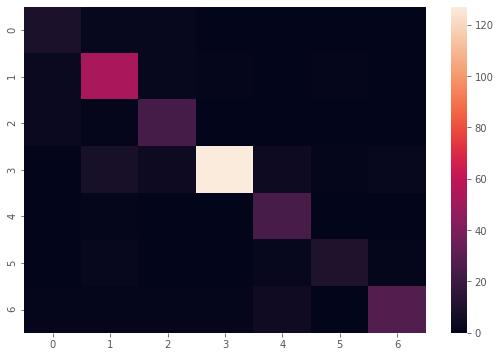

In [44]:
plt.figure(2, figsize=(9, 6))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred))

In [45]:
# plot confusion matrix
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [9, 7]
plot_confusion_matrix(clf, X_test_pca, y_test, cmap=plt.cm.Blues, display_labels=range(n_classes))

ValueError: ignored

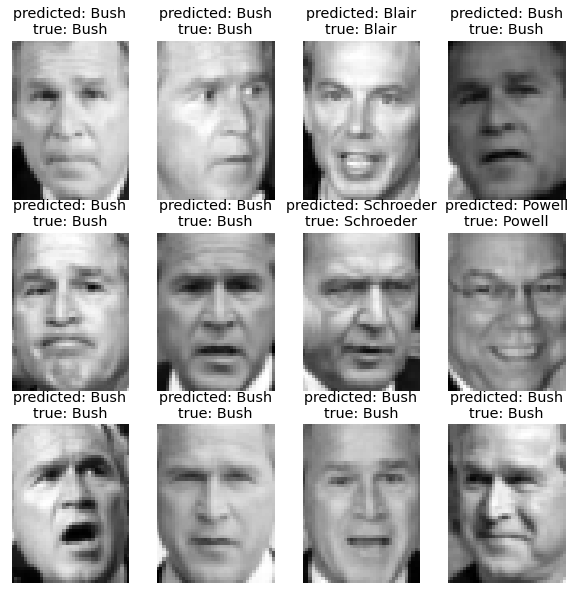

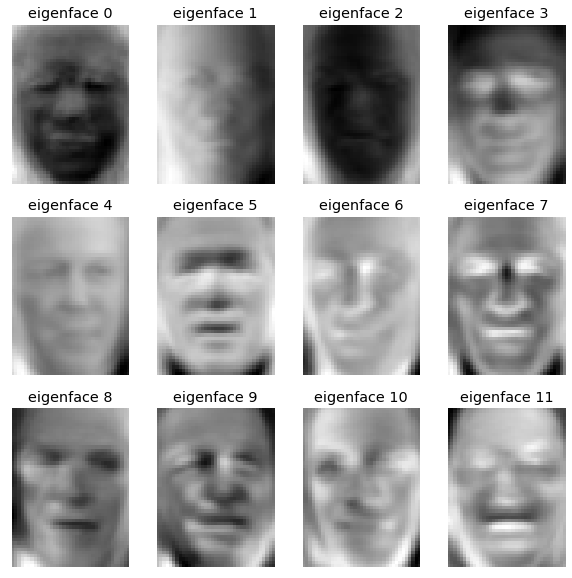

In [17]:
prediction_titles = list(titles(y_pred, y_test, target_names))
plot_gallery(X_test, prediction_titles, h, w)

eigenface_titles = ["eigenface {0}".format(i) for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [20]:
ica = FastICA(n_components=n_components,
          whiten = True).fit(X_train)

eigenfaces = ica.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")

X_train_ica = ica.transform(X_train)
X_test_ica = ica.transform(X_test)

Projecting the input data on the eigenfaces orthonormal basis


In [21]:
print("Sample Data point after applying ICA\n", X_train_ica[0])
print("-----------------------------------------------------")
print("Dimesnsions of training set = % s and Test Set = % s"%(
        X_train.shape, X_test.shape))
        
print("Fitting the classifier to the training set")

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel ='rbf', class_weight ='balanced'), param_grid
)
clf = clf.fit(X_train_ica, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
  
print("Predicting people's names on the test set")

y_pred = clf.predict(X_test_ica)

print("Accuracy score:{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))

# print classifiction results
print(classification_report(y_test, y_pred, target_names = target_names))
# print confusion matrix
print("Confusion Matrix is:")
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Sample Data point after applying ICA
 [ 1.51902599e-03  1.56110340e-02 -8.88492846e-03 -1.24158726e-03
  2.47888862e-02  3.67275297e-02  1.16203021e-01  2.52320714e-03
 -4.27373077e-02  3.82995319e-01 -1.59244128e-02  7.27608453e-02
 -3.44072063e-02 -4.48427751e-02  3.54447704e-03 -3.11529946e-02
 -5.45945814e-02  7.95028034e-02  7.76421669e-03 -1.57701660e-02
  9.27013934e-03  1.72215243e-02 -3.35598718e-03 -1.85708097e-02
  1.35502569e-02 -4.65572292e-02  3.62024099e-02 -1.66204979e-03
 -4.04526424e-02  1.17887652e-02 -2.24533683e-03 -1.91245140e-02
 -1.25627919e-02  4.94276176e-03  7.80322058e-03  2.02908625e-02
  1.18690629e-02 -4.08495583e-02  6.41821725e-02  4.06867048e-02
 -4.23152274e-02  2.83469345e-02 -5.93446140e-02  1.35753046e-02
  2.73953047e-02 -6.11276306e-03 -9.61883557e-05  4.92701067e-03
  9.70817900e-03 -9.33124506e-03 -2.00857349e-02 -3.23703928e-02
  8.91440915e-03 -8.64416785e-03  2.58102186e-02 -8.18278221e-03
 -2.00267049e-02 -8.83243517e-03 -9.62712170e-03 -9.

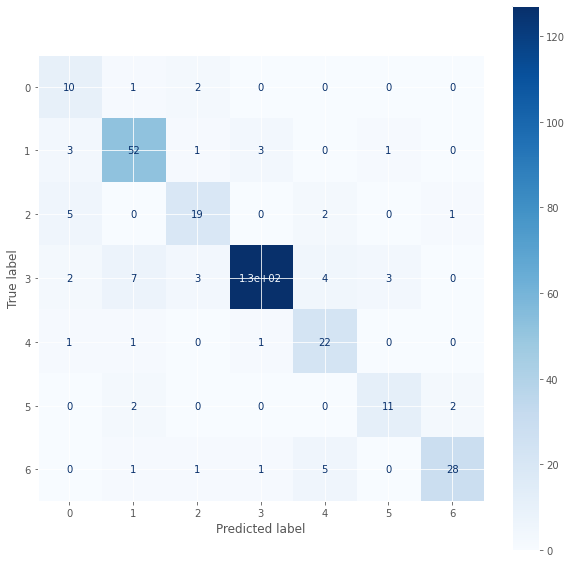

In [22]:
# plot confusion matrix
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [9, 7]
plot_confusion_matrix(clf, X_test_ica, y_test, cmap=plt.cm.Blues, display_labels=range(n_classes))

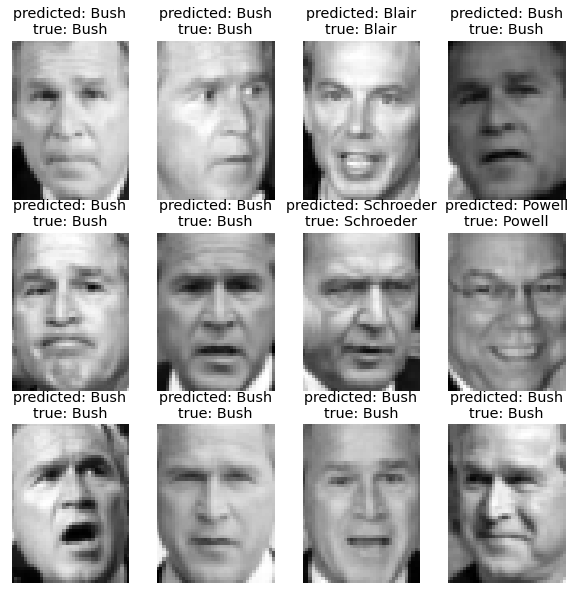

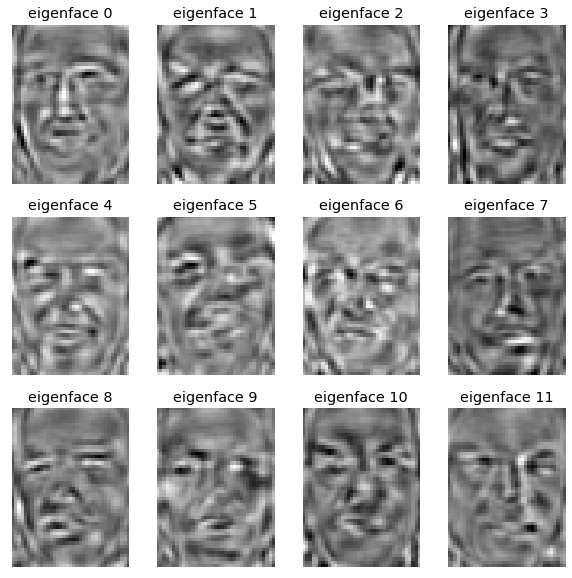

In [23]:
prediction_titles = list(titles(y_pred, y_test, target_names))
plot_gallery(X_test, prediction_titles, h, w)

eigenface_titles = ["eigenface {0}".format(i) for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [37]:
pca = PCA(n_components = 150, svd_solver='randomized', whiten=True).fit(X_train)
lda = LDA().fit(pca.transform(X_train), y_train)
print("done in %0.3fs" % (time() - t0))

print("Projecting the input data on the eigenfaces orthonormal basis")

X_train_lda = lda.transform(pca.transform(X_train))
X_test_lda = lda.transform(pca.transform(X_test))
print("done in %0.3fs" % (time() - t0))

done in 1486.751s
Projecting the input data on the eigenfaces orthonormal basis
done in 1486.774s


In [38]:
def plot_images_lda(pca, lda, titles, h, w, n_row=1, n_col=4):
    plt.figure()
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(pca.inverse_transform(lda.scalings_[:, i]).reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

    plt.show()

In [39]:
print("Sample Data point after applying LDA\n", X_train_lda[0])
print("-----------------------------------------------------")
print("Dimesnsions of training set = % s and Test Set = % s"%(
        X_train.shape, X_test.shape))
        
print("Fitting the classifier to the training set")

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel ='rbf', class_weight ='balanced'), param_grid
)
clf = clf.fit(X_train_lda, y_train)
print("Done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
  
print("Predicting people's names on the test set")

y_pred = clf.predict(X_test_lda)

print("Accuracy score:{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
# print classifiction results
print(classification_report(y_test, y_pred, target_names = target_names))
# print confusion matrix
print("Confusion Matrix is:")
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Sample Data point after applying LDA
 [ 1.47982202 -0.06564699 -1.51088194 -3.84185849 -0.21277734  1.18722917]
-----------------------------------------------------
Dimesnsions of training set = (966, 1850) and Test Set = (322, 1850)
Fitting the classifier to the training set
Done in 1495.125s
Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0001,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Predicting people's names on the test set
Accuracy score:84.78%
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.78      0.88      0.83        60
  Donald Rumsfeld       0.72      0.85      0.78        27
    George W Bush       0.98      0.87      0.92       146
Gerhard Schroeder       0.69      0.96      0.80 

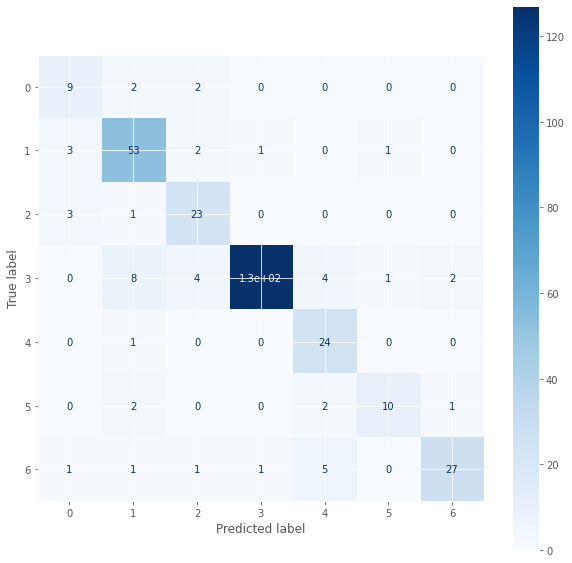

In [40]:
# plot confusion matrix
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [9, 7]
plot_confusion_matrix(clf, X_test_lda, y_test, cmap=plt.cm.Blues, display_labels=range(n_classes))

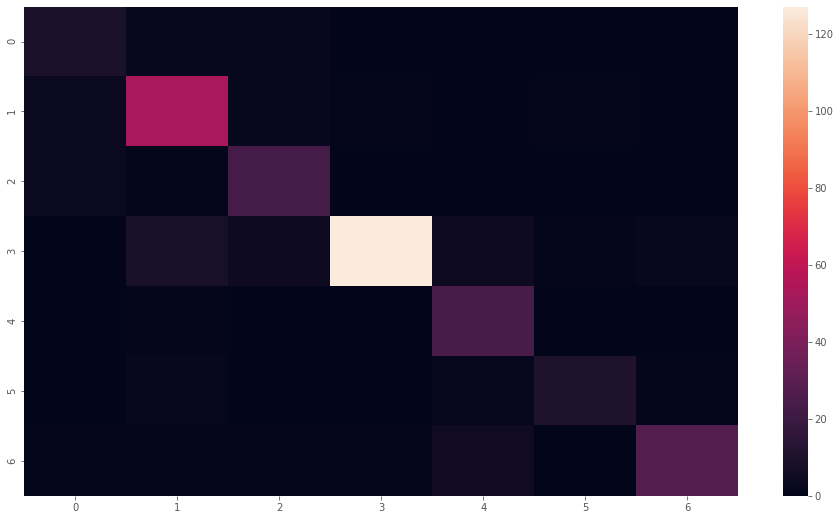

In [41]:
plt.figure(2, figsize=(9, 6))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred))

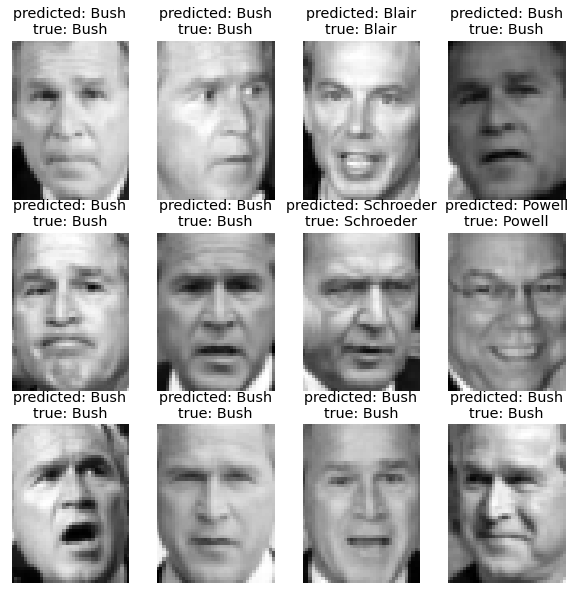

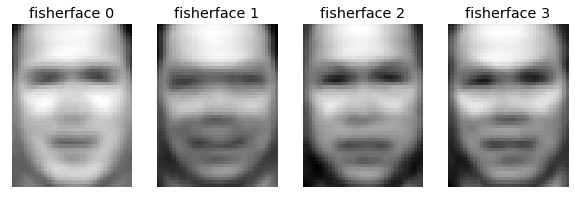

In [42]:
prediction_titles = list(titles(y_pred, y_test, target_names))
plot_gallery(X_test, prediction_titles, h, w)

fisherface_titles = ["fisherface %d" % i for i in range(4)]
plot_images_lda(pca, lda, fisherface_titles, h, w)

plt.show()